In [1]:
from b_field import structured_field
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import simps
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import MaxNLocator
from gammaALPs.nel.icm import NelICM
%matplotlib inline

In [2]:
def cart_to_sphere(x2, y2, z2):
    r2 = np.sqrt(x2**2 + y2**2 + z2**2)
    theta2 = np.arccos(z2 / r2)
    phi2 = np.arctan2(y2, x2)
    return r2, theta2, phi2

def sphere_to_cart(r, theta, phi):
    x1 = r * np.sin(theta) * np.cos(phi)
    y1 = r * np.sin(theta) * np.sin(phi)
    z1 = r * np.cos(theta)
    return x1, y1, z1


alpha = 5.7634591968
c = 1
F_0 = c * (alpha * np.cos(alpha) - np.sin(alpha)) * alpha**2
norm_ = np.sqrt((3 * F_0 + alpha**5)**2) * 2 / (3 * alpha**2)

def trafo(r, theta, phi):
    '''Returns trafo used for vector fields, i.e. Field A cartesian = S * Field A spherical. S is returned'''
    mat = np.array([[np.sin(theta) * np.cos(phi), np.cos(theta) * np.cos(phi), -np.sin(phi)],
                    [np.sin(theta) * np.sin(phi), np.cos(theta) * np.sin(phi), np.cos(phi)],
                    [np.cos(theta), -np.sin(theta), 0]])
        #outdata[c, :, :] = mat[:, :]
    
    return mat


def rotation(n, x, angle):
    return n * np.inner(n, x) + np.cos(angle) * np.cross(np.cross(n, x), n) + np.sin(angle) * np.cross(n, x)

def cart_rotation(alpha, beta):
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot_z

def b_r(r, theta):
    
    zero_val = - np.cos(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = 2 * np.cos(theta) * f(r) / r**2
    if r > 1:
        val = 0
    return b0 / norm_ * val
    

def b_theta(r, theta):
    zero_val = np.sin(theta) * (6 * F_0 + 2 * alpha**5 * c) / (3 * alpha**2)
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = - np.sin(theta) * f_prime(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def b_phi(r, theta):
    zero_val = 0
    if np.isclose(r, 0):
        val = zero_val
    else:
        val = alpha * np.sin(theta) * f(r) / r
    if r > 1:
        val = 0
    return b0 / norm_ * val


def f(r):
    return c * (alpha * np.cos(alpha * r) - np.sin(alpha * r) / r) \
           - F_0 * r**2 / alpha**2


def f_prime(r):
    return c * ( - alpha**2 * np.sin(alpha * r) \
                - alpha * np.cos(alpha * r) / r \
                + np.sin(alpha * r) / r**2) \
               - 2 * F_0 * r / alpha**2

def B_sphere(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    #print(r, theta, phi)
    return np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])

def B_cart(x1, x2, x3, sys='cart'):
    if sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif sys == 'sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    B_sph = B_sphere(r, theta, phi, sys='sph')
    #print(B_sph)
    t = trafo(r, theta, phi)
    #print(B_sph.shape)
    #print(t)
    B_c = np.matmul(trafo(r, theta, phi), B_sph.transpose()).transpose()
    return B_c
    

def rotation_measure(z, b_par, nel):
    #print(z)
    #print(b_par)
    #print(nel)
    return 812 * simps(b_par * nel, z)

def projection(field, direction):
    return np.inner(field, direction)

def axis_helper(x):
    l = x.shape[0]
    dx = x[1] - x[0]
    return np.linspace(x[0] - dx / 2, x[-1] + dx / 2, num=l + 1)


def B(x1, x2, x3, in_sys, out_sys):
    #get input coordinates
    if in_sys == 'cart':
        r, theta, phi = cart_to_sphere(x1, x2, x3)
    elif in_sys=='sph':
        r, theta, phi = x1, x2, x3
    else:
        print('wrong coords')
    
    #calculate bfield
    B = np.array([b_r(r / R, theta), b_theta(r / R, theta), b_phi(r / R, theta)])
    
    #get output coordinates
    if out_sys == 'sph':
        return B
    elif out_sys == 'cart':
        return np.matmul(trafo(r, theta, phi), B.transpose()).transpose()

#def kpc_to_arcmin()



In [67]:
def make_rm(R=93, b0=8.3, theta=0, phi=0, num=10):
    #th in degrees
    nel = NelICM(n0 = 39., n2 = 4.05, r_abell = 500., r_core = 80., r_core2 = 280., beta = 1.2, beta2= 0.58, eta = 0.5)
    theta_rad = np.radians(theta)
    e_x = np.array([1, 0, 0])
    dipole = np.array([[0, 0, -1], [0, 0, 1]])   # N, S
    #init coordinate space
    x = np.linspace(-R, R, num=num)
    y = np.linspace(-R, R, num=num)
    #x = np.array([0])
    #y = np.array([0])
    z = np.linspace(0, R, num=num)
    
    #get meshgrid
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    rotx, rotz = cart_rotation(np.radians(theta), np.radians(phi))
    rotxz = np.matmul(rotx, rotz)    # first rotate around LOS, then tilt w.r.t. LOS.
    # should be wrong like this! needs rotation around the tilted normal/LOS vector!
    XR = np.zeros(X.shape).flatten()
    YR = np.zeros(Y.shape).flatten()
    ZR = np.zeros(Z.shape).flatten()
    
    # rotate integration direction, i.e. e_y
    e_z = np.array([0, 0, 1])
    r_e_z = np.matmul(rotx, e_z.transpose()).transpose()
    r_e_x = np.matmul(rotz, e_x.transpose()).transpose()
    r_dipole = np.zeros(dipole.shape)
    r_dipole[0] = rotation(r_e_x, dipole[0], np.radians(theta))
    r_dipole[1] = rotation(r_e_x, dipole[1], np.radians(theta))
    #print(r_dipole)

    # rotate coordinate grid
    for c_, (x_, y_, z_) in enumerate(zip(X.flatten(), Y.flatten(), Z.flatten())):
        rot = np.matmul(rotxz, np.array([x_, y_, z_]).transpose()).transpose()
        XR[c_] = rot[0]
        YR[c_] = rot[1]
        ZR[c_] = rot[2]
    
    XR = XR.reshape(X.shape)
    YR = YR.reshape(Y.shape)
    ZR = ZR.reshape(Z.shape)
    B_C = np.zeros((x.shape[0] * y.shape[0] * z.shape[0], 3))
    c_list = list(zip(XR.flatten(), YR.flatten(), ZR.flatten()))
    for c_, (x_, y_, z_) in enumerate(c_list):
        r_, theta_, phi_ = cart_to_sphere(x_, y_, z_)
        #print(r_, theta_, phi_)
        if np.isnan(theta_):
            #check for previous and next few entries for r=0 and take their theta
            print(c_)
            _, theta_, _ = cart_to_sphere(*c_list[c_ + 1])
        g = B_cart(r_, theta_, phi_, sys='sph')
        B_C[c_] = g
        #print(g)
    R_mesh, _, _ = cart_to_sphere(XR, YR, ZR)
    NEL = nel(R_mesh)*1e-3
    B_C = B_C.reshape((x.shape[0], y.shape[0], z.shape[0], 3))
    #print(r_e_y)
    #print(B_C.shape)
    #print("B_C")
    #print(B_C)
    B_proj = np.inner(B_C, r_e_z)
    #print("b_proj")
    #print(B_proj.shape)
    print("LOS", r_e_z)
    rm = np.zeros((x.shape[0], y.shape[0]))
    #print(NEL)
    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            rm[i, j] = rotation_measure(z, B_proj[i, j, :], NEL[i, j, :])

    return x, y, z, r_dipole, rm
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(X, Y, Z)
    ax.scatter(XR, YR, ZR)
    ax.plot([0, e_z[0]], [0, e_z[1]], [0, e_z[2]])
    ax.plot([0, r_e_z[0]], [0, r_e_z[1]], [0, r_e_z[2]])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

1680
LOS [0. 0. 1.]


/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/julian/anaconda3/envs/fermi3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


"\niax = ax.inset_axes([0, 0, 0.23, 0.23])\niax.set_xlim(-1.15, 1.15)\niax.set_ylim(-1.15, 1.15)\niax.scatter(dip[:, 0], dip[:, 1], c=['red', 'green'])\nrect = [0.45, 0.6, 0.3, 0.3]\nax_inset = fig.add_axes(rect, anchor='NE', projection='3d')\nax_inset.view_init(elev=theta+90, azim=90+phi)\nax_inset.scatter(*dip[0], c='red')\nax_inset.scatter(*dip[1], c='green')\nax_inset.patch.set_alpha(0.)\n#iax.set_xticks([], [])\n#iax.set_yticks([], [])\n"

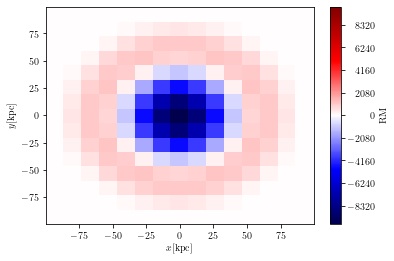

In [69]:
R = 93
b0 = 8.3
phi = 0
theta = 0
#make_rm(theta=theta, phi=phi, num=20)
x, y, z, dip, rm = make_rm(theta=theta, phi=phi, num=15)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
cmap = plt.get_cmap('seismic')
x_h = axis_helper(x)
y_h = axis_helper(y)
levels = MaxNLocator(nbins=cmap.N).tick_values(-1e4, 1e4)
norm = BoundaryNorm(levels, cmap.N)
pcol = ax.pcolor(x_h, y_h, rm, cmap=cmap, norm=norm, alpha=1)
cb = fig.colorbar(pcol, ax=ax, extend='neither', label='RM')
ticklabels = cb.ax.get_yticklabels()
cb.ax.set_yticklabels(ticklabels, ha='right')
cb.ax.yaxis.set_tick_params(pad=30)
ax.set_xlabel('$x [\SI{}{\kilo\parsec}]$')
ax.set_ylabel('$y [\SI{}{\kilo\parsec}]$')
'''
iax = ax.inset_axes([0, 0, 0.23, 0.23])
iax.set_xlim(-1.15, 1.15)
iax.set_ylim(-1.15, 1.15)
iax.scatter(dip[:, 0], dip[:, 1], c=['red', 'green'])
rect = [0.45, 0.6, 0.3, 0.3]
ax_inset = fig.add_axes(rect, anchor='NE', projection='3d')
ax_inset.view_init(elev=theta+90, azim=90+phi)
ax_inset.scatter(*dip[0], c='red')
ax_inset.scatter(*dip[1], c='green')
ax_inset.patch.set_alpha(0.)
#iax.set_xticks([], [])
#iax.set_yticks([], [])
'''


In [44]:
rm

array([[-10041.59123688]])

B_C
[[[[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]]


 [[[ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]
   [ 0.          0.          0.        ]]

  [[ 0.          0.          0.        ]
   [ 0.98144246  3.63084143 -0.43746288]
   [-3.74845092  1.32221395 -0.03038957]
   [ 0.          0.          0.        ]]

<IPython.core.display.Javascript object>


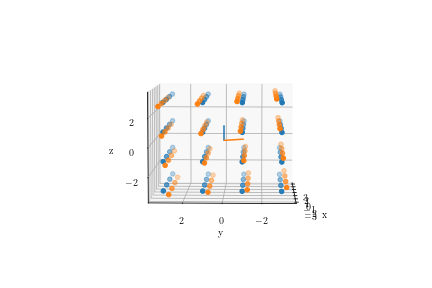

In [261]:
R = 3
b0 = 8.3
phi = 0
theta = 85
%matplotlib notebook
make_rm(R=R, b0=b0, num=4, theta=theta, phi=phi)

In [264]:
R = 93
x = 30
y = np.linspace(-R, R, num=10)
z = 0
# xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
integral = 0
for y_ in y:
    bc = B_cart(x, y_, z, sys='cart')
    r, _, _ = cart_to_sphere(x, y_, z)
    
    print(bc)
    integral += nel(r)*1e-3 * np.inner(bc, np.array([0, -1, 0]))
print(integral)

[0. 0. 0.]
[-0.72509749 -0.30073168  1.51267123]
[-2.93643923 -1.70502923  1.57631132]
[-3.9020031  -3.77613204 -0.89122715]
[-1.83321329 -5.32223214 -3.50400377]
[ 1.83321329 -5.32223214 -3.50400377]
[ 3.9020031  -3.77613204 -0.89122715]
[ 2.93643923 -1.70502923  1.57631132]
[ 0.72509749 -0.30073168  1.51267123]
[0. 0. 0.]
0.6602354968828604


In [106]:
fig.savefig('rm_theta_45_90.png')

(-1.0, 1.0)

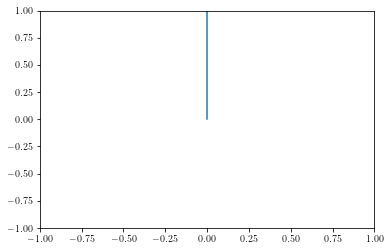

In [102]:
n = np.array([0, 1])
plt.plot((0, 0), (0, 1))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

<IPython.core.display.Javascript object>


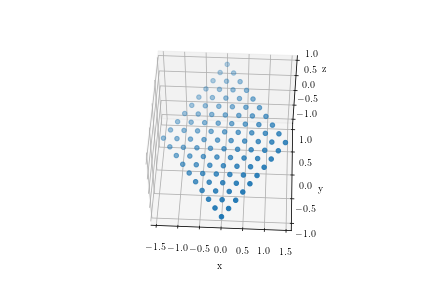

Text(0.5, 0, 'z')

In [81]:
def cart_rotation(alpha, beta):
    rot_x = np.array([[1,             0,              0],
                      [0, np.cos(alpha), -np.sin(alpha)],
                      [0, np.sin(alpha),  np.cos(alpha)]])
    rot_y = np.array([[ np.cos(beta), 0, np.sin(beta)],
                      [            0, 1,            0],
                      [-np.sin(beta), 0, np.cos(beta)]])
    rot_z = np.array([[np.cos(beta), -np.sin(beta), 0],
                      [np.sin(beta),  np.cos(beta), 0],
                      [           0,             0, 1]])
    return rot_x, rot_z
%matplotlib notebook
x = np.linspace(-1, 1, num=10)
y = np.linspace(-1, 1, num=10)
z = np.zeros(1)
xx, yy, zz = np.meshgrid(x, y, z, indexing='ij')
rotx, rotz = cart_rotation(np.pi/4, np.pi/4)
rotzx = np.matmul(rotx, rotz)
xxr, yyr, zzr = np.zeros((xx.flatten().shape)), np.zeros((xx.flatten().shape)), np.zeros((xx.flatten().shape))
for c_, (x_, y_, z_) in enumerate(zip(xx.flatten(), yy.flatten(), zz.flatten())):
    rot = np.matmul(rotzx, np.array([x_, y_, z_]).transpose()).transpose()
    xxr[c_] = rot[0]
    yyr[c_] = rot[1]
    zzr[c_] = rot[2]
    
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(xxr, yyr, zzr)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

In [71]:
from scipy.spatial.transform import Rotation as R

In [72]:
r = R.from_rotvec(np.pi/2 * np.array([0, 0, 1]))

In [73]:
r.as_matrix()

array([[ 2.22044605e-16, -1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  2.22044605e-16,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])